In [1]:
# Clone the repo so Colab can access all the files, including utilities.py
!git clone https://github.com/PouyaRepos/sequential_anomaly_detection.git
%cd sequential_anomaly_detection


fatal: destination path 'sequential_anomaly_detection' already exists and is not an empty directory.
/Users/pouyaabbasi/Documents/Projects/sequential_anomaly_detection/sequential_anomaly_detection


In [ ]:
from utilities import NoisyLearningAlgorithm
import itertools
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from pykalman import KalmanFilter
from scipy.fft import fft, ifft
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from lightgbm import LGBMClassifier

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq




In [242]:
# Download dataset and import into Pandas DataFrame
path = kagglehub.dataset_download("mayurgadekar5555/industrial-equipment-maintenance-data")
print("Path to dataset files:", path)
file_path = f"{path}/data/raw/equipment_data.csv"
data = pd.read_csv(file_path)
data.head(5)
# df.tail(5)
# print(df.info())

Path to dataset files: /Users/pouyaabbasi/.cache/kagglehub/datasets/mayurgadekar5555/industrial-equipment-maintenance-data/versions/1


,Timestamp,Temperature (°C),Vibration (mm/s),Pressure (Pa),RPM,Maintenance Required,Temp_Change,Vib_Change
0,2019-01-01 00:00:00,0.548793,0.509840,0.619918,0.741161,1,0.501129,0.499619
1,2019-01-01 01:00:00,0.715185,0.587573,0.802121,0.292862,1,0.584882,0.538630
2,2019-01-01 02:00:00,0.602748,0.294453,0.965546,0.624416,1,0.444534,0.352514
3,2019-01-01 03:00:00,0.544862,0.500041,0.519955,0.931955,0,0.471992,0.602794
4,2019-01-01 04:00:00,0.423622,0.031649,0.323663,0.799867,0,0.440103,0.264552


In [243]:
# rename columns
df = data.copy()
df.columns
columns = ['Timestamp', 'Temperature', 'Vibration', 'Pressure', 'RPM', 'Maintenance Required', 'Temp_Change', 'Vib_Change']
df.columns = columns

In [244]:

# 1. Sort Data
df.sort_values('Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)


,Timestamp,Temperature,Vibration,Pressure,RPM,Maintenance Required,Temp_Change,Vib_Change
0,2019-01-01 00:00:00,0.548793,0.509840,0.619918,0.741161,1,0.501129,0.499619
1,2019-01-01 01:00:00,0.715185,0.587573,0.802121,0.292862,1,0.584882,0.538630
2,2019-01-01 02:00:00,0.602748,0.294453,0.965546,0.624416,1,0.444534,0.352514
3,2019-01-01 03:00:00,0.544862,0.500041,0.519955,0.931955,0,0.471992,0.602794
4,2019-01-01 04:00:00,0.423622,0.031649,0.323663,0.799867,0,0.440103,0.264552


In [245]:
df.describe()


,Temperature,Vibration,Pressure,RPM,Maintenance Required,Temp_Change,Vib_Change
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,0.497752,0.500139,0.502902,0.500764,0.500776,0.501133,0.499622
std,0.289543,0.288612,0.289589,0.288880,0.500005,0.206076,0.205033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.246304,0.248662,0.250924,0.250167,0.000000,0.352515,0.352197
50%,0.497589,0.500018,0.504503,0.503002,1.000000,0.501690,0.498956
75%,0.749073,0.749795,0.755002,0.749166,1.000000,0.649000,0.647563
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             43800 non-null  object 
 1   Temperature           43800 non-null  float64
 2   Vibration             43800 non-null  float64
 3   Pressure              43800 non-null  float64
 4   RPM                   43800 non-null  float64
 5   Maintenance Required  43800 non-null  int64  
 6   Temp_Change           43800 non-null  float64
 7   Vib_Change            43800 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.7+ MB


In [246]:
# 2. Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Timestamp               0
Temperature             0
Vibration               0
Pressure                0
RPM                     0
Maintenance Required    0
Temp_Change             0
Vib_Change              0
dtype: int64


In [247]:
#check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [248]:
# check for min and max of timestamp
min_timestamp = df['Timestamp'].min()
max_timestamp = df['Timestamp'].max()

print(f"Min timestamp: {min_timestamp}")
print(f"Max timestamp: {max_timestamp}")

# length of the dataset
length_of_dataset = len(df)
print(f"Length of the dataset: {length_of_dataset}")

Min timestamp: 2019-01-01 00:00:00
Max timestamp: 2023-12-30 23:00:00
Length of the dataset: 43800


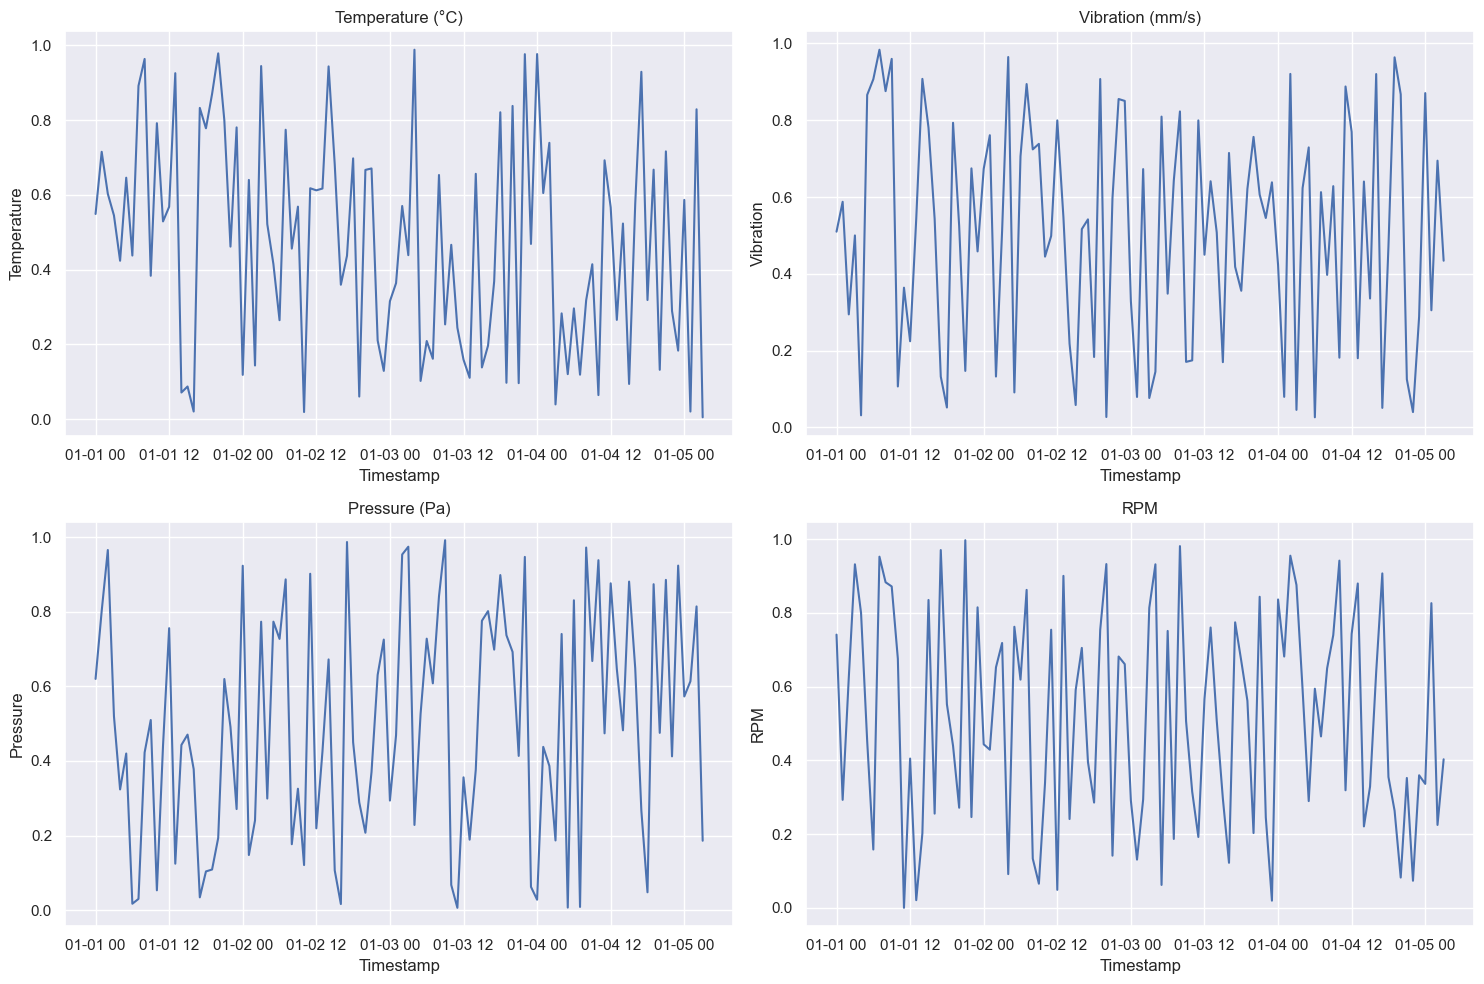

In [268]:
# plot Temperature (°C)	Vibration (mm/s)	Pressure (Pa)	RPM	Temp_Change	Vib_Change 


N = 100 # Every Nth row
df_truncated = df.iloc[::N, :]


N = 100 # First N rows
df_truncated = df.iloc[:N, :]

# Plot the data
sns.set(style="darkgrid")
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.lineplot(x='Timestamp', y='Temperature', data = df_truncated)
plt.title('Temperature (°C)')
plt.subplot(2, 2, 2)
sns.lineplot(x='Timestamp', y='Vibration', data= df_truncated)
plt.title('Vibration (mm/s)')
plt.subplot(2, 2, 3)
sns.lineplot(x='Timestamp', y='Pressure', data= df_truncated)
plt.title('Pressure (Pa)')
plt.subplot(2, 2, 4)
sns.lineplot(x='Timestamp', y='RPM', data= df_truncated)
plt.title('RPM')
plt.tight_layout()
plt.show()

# Fourier Transform

In [251]:
def fft_denoise_full(signal: np.ndarray, time_seconds: np.ndarray, percentile: float = 99.5) -> tuple:
    n = len(signal)
    dt = np.mean(np.diff(time_seconds))
    Fs = 1 / dt if dt > 0 else np.nan

    fft_vals = fft(signal)
    freqs = fftfreq(n, d=1/Fs)
    magnitude = np.abs(fft_vals)
    threshold = np.percentile(magnitude, percentile)
    fft_denoised = np.where(magnitude > threshold, fft_vals, 0)
    cleaned_signal = np.real(ifft(fft_denoised))

    return cleaned_signal, freqs, magnitude, threshold


In [252]:
# Plotting the results
def plot_fft_denoising_results(fft_results, df, time_seconds, feature_cols, N=100):
    """
    Visualize FFT denoising results for multiple columns.

    Parameters:
    - fft_results: dict from earlier (output of fft_denoise_full for each column)
    - df: original DataFrame
    - time_seconds: array of time values
    - feature_cols: list of columns to visualize
    - N: number of time samples to show (default: 100)
    """

    for col in feature_cols:
        cleaned_signal, freqs, magnitude, threshold = fft_results[col]
        original_signal = df[col].values

        # Slice to first N samples
        time_subset = time_seconds[:N]
        original_subset = original_signal[:N]
        cleaned_subset = cleaned_signal[:N]

        # Plot original vs denoised (first N samples)
        plt.figure(figsize=(10, 4))
        plt.plot(time_subset, original_subset, label="Original Signal", alpha=0.6)
        plt.plot(time_subset, cleaned_subset, label="Denoised Signal", linewidth=2)
        plt.legend()
        plt.title(f"{col} - Denoising using FFT (First {N} Samples)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        # Plot FFT magnitude spectrum (full)
        plt.figure(figsize=(10, 4))
        plt.plot(freqs[:len(freqs)//2], magnitude[:len(magnitude)//2], label="Magnitude Spectrum")
        plt.axhline(threshold, color='red', linestyle='--', label=f"Threshold ({threshold:.2f})")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.title(f"{col} - FFT Spectrum with Threshold")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [253]:
feature_cols = ['Temperature', 'Vibration', 'Pressure', 'RPM', 'Temp_Change', 'Vib_Change']

# Make sure timestamp is datetime and sorted
df = df.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)
time_seconds = (df['Timestamp'] - df['Timestamp'].iloc[0]).dt.total_seconds().values

# Apply to all features and collect outputs
fft_results = df[feature_cols].apply(
    lambda col: fft_denoise_full(col.values, time_seconds, percentile=99.0)
)

# Store results in DataFrame
for col in feature_cols:
    df[f"{col}_Denoised"] = fft_results[col][0]  # cleaned_signal


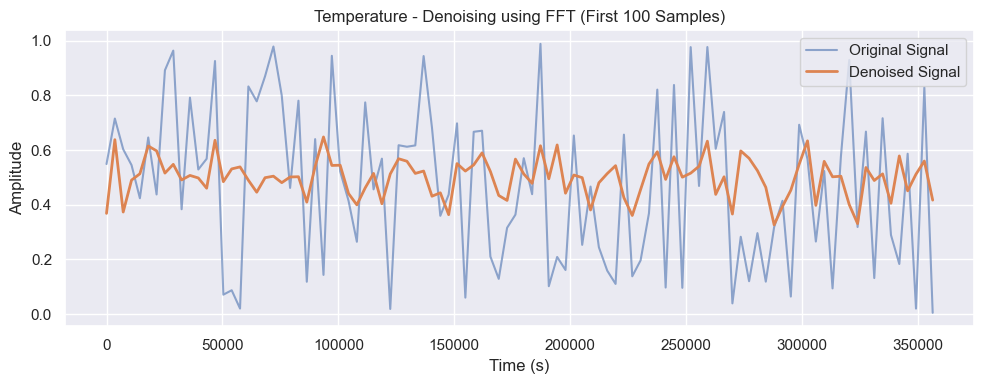

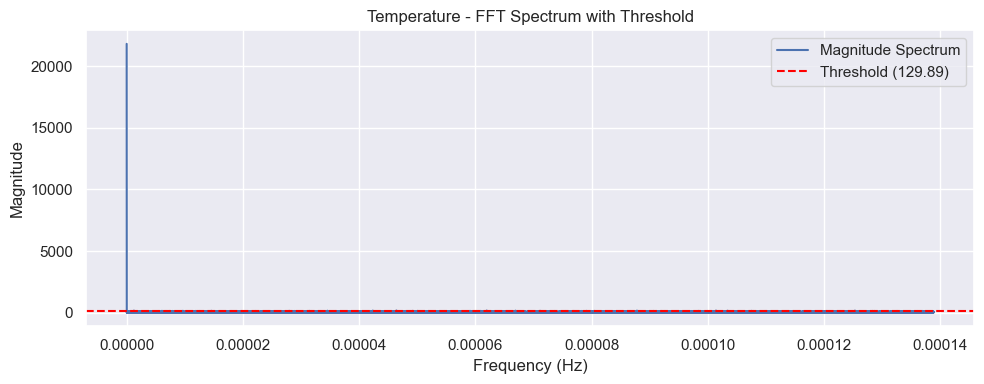

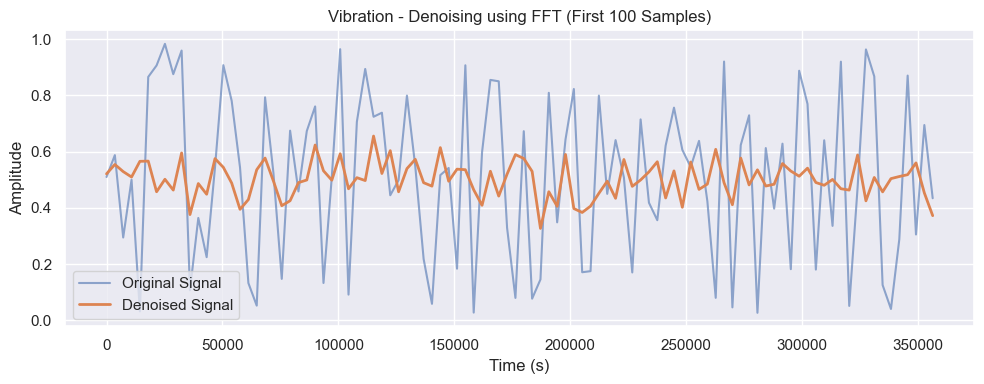

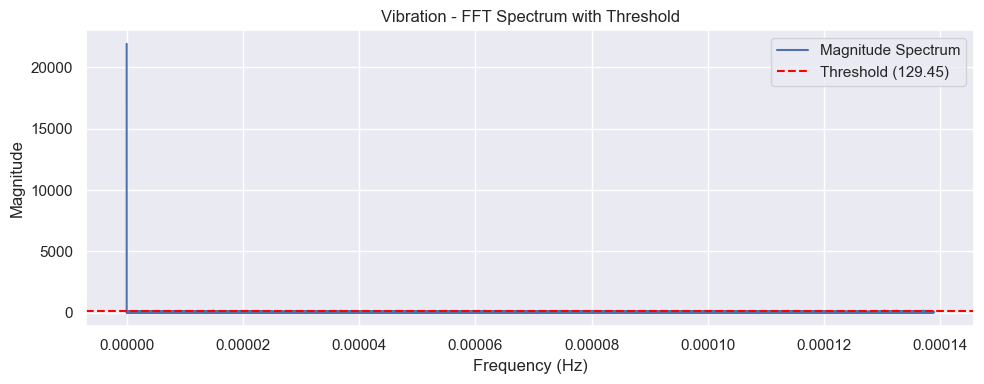

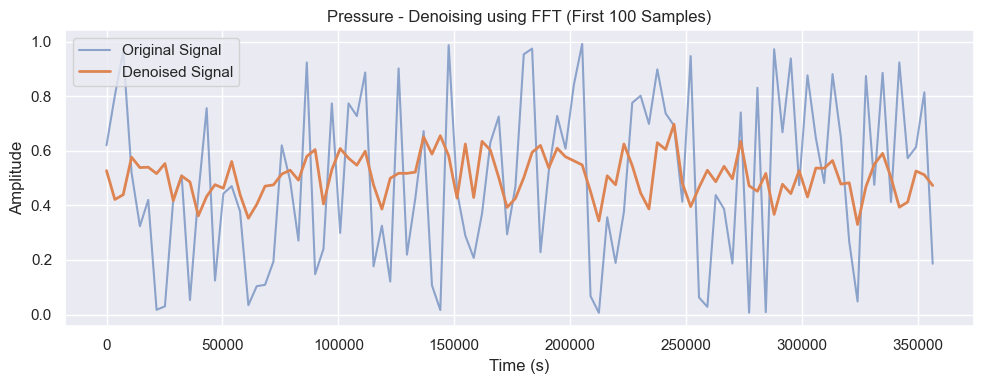

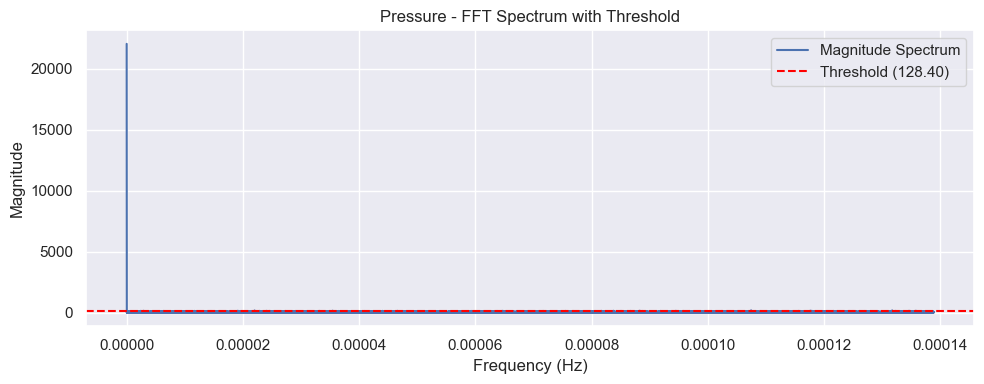

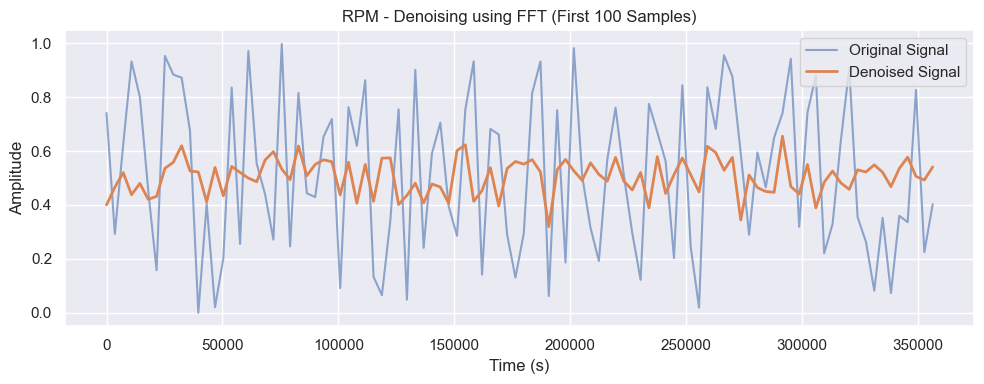

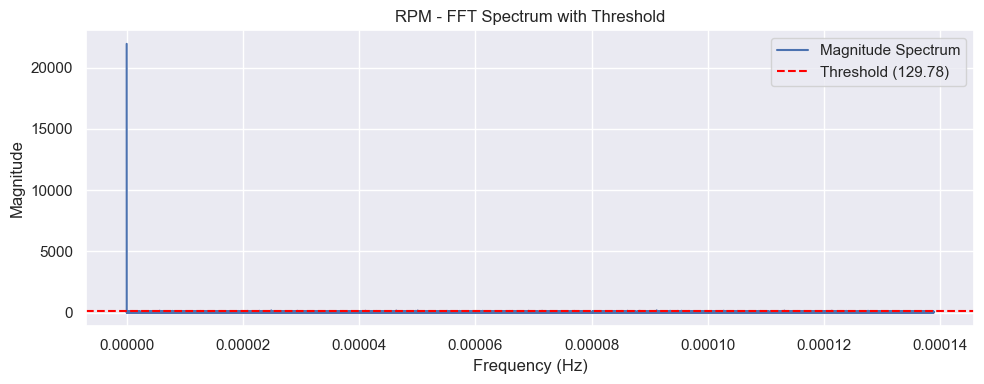

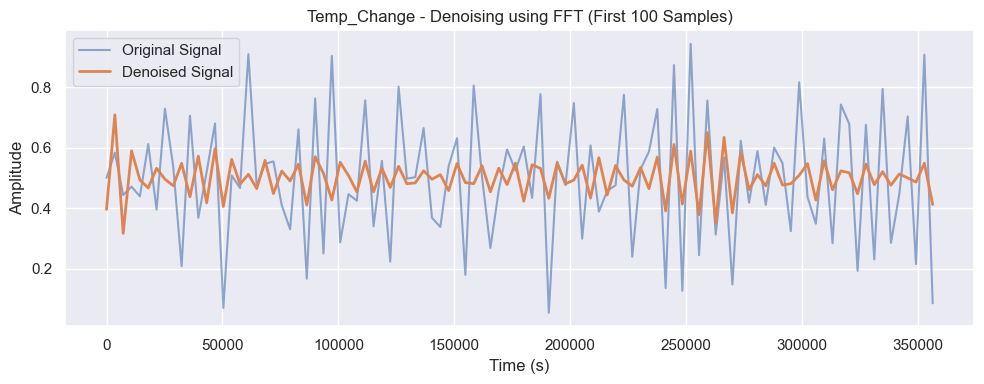

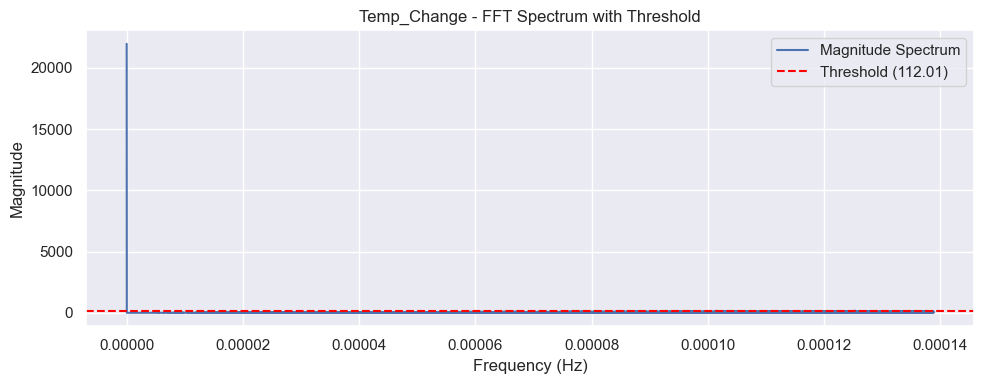

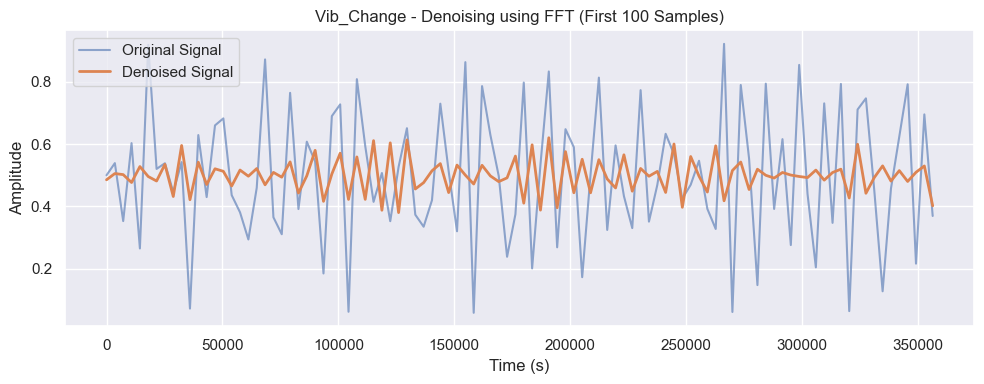

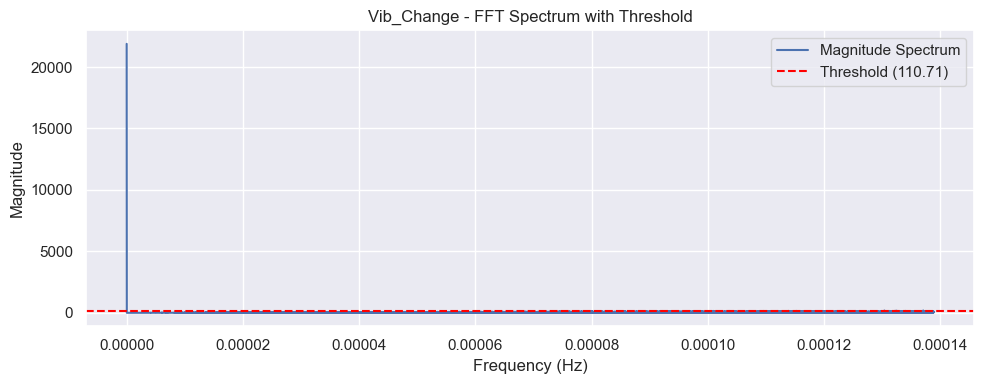

In [254]:
plot_fft_denoising_results(fft_results, df, time_seconds, feature_cols, N=100)

In [255]:
df.head(5)

,Timestamp,Temperature,Vibration,Pressure,RPM,Maintenance Required,Temp_Change,Vib_Change,Temperature_Denoised,Vibration_Denoised,Pressure_Denoised,RPM_Denoised,Temp_Change_Denoised,Vib_Change_Denoised
0,2019-01-01 00:00:00,0.548793,0.509840,0.619918,0.741161,1,0.501129,0.499619,0.368311,0.520909,0.527173,0.400263,0.396937,0.485049
1,2019-01-01 01:00:00,0.715185,0.587573,0.802121,0.292862,1,0.584882,0.538630,0.637895,0.554340,0.421525,0.465614,0.709405,0.505130
2,2019-01-01 02:00:00,0.602748,0.294453,0.965546,0.624416,1,0.444534,0.352514,0.373279,0.528997,0.439053,0.519996,0.317609,0.501697
3,2019-01-01 03:00:00,0.544862,0.500041,0.519955,0.931955,0,0.471992,0.602794,0.490069,0.509714,0.576515,0.437853,0.590665,0.476364
4,2019-01-01 04:00:00,0.423622,0.031649,0.323663,0.799867,0,0.440103,0.264552,0.513202,0.565542,0.538469,0.479757,0.494213,0.527599


# Corralation for features before Fourier Transform

Index(['Timestamp', 'Maintenance Required', 'Temperature', 'Vibration',
       'Pressure', 'RPM', 'Temp_Change', 'Vib_Change'],
      dtype='object')


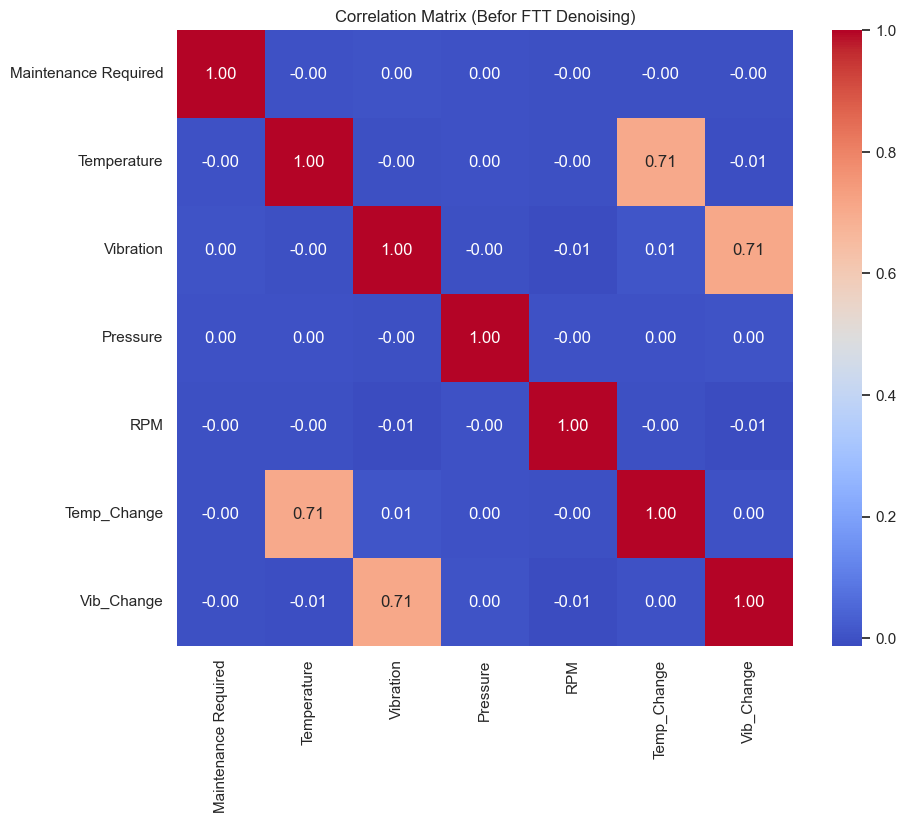

In [276]:
df_noised = df[['Timestamp'] + ['Maintenance Required'] + feature_cols].copy()
print(df_noised.columns)

# correlation matrix
plt.figure(figsize=(10, 8))
corr = df_noised.drop(columns=['Timestamp']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix (Befor FTT Denoising)')
plt.show()



# Corralation for features AFTER Fourier Transform

Index(['Timestamp', 'Maintenance Required', 'Temperature_Denoised',
       'Vibration_Denoised', 'Pressure_Denoised', 'RPM_Denoised',
       'Temp_Change_Denoised', 'Vib_Change_Denoised'],
      dtype='object')


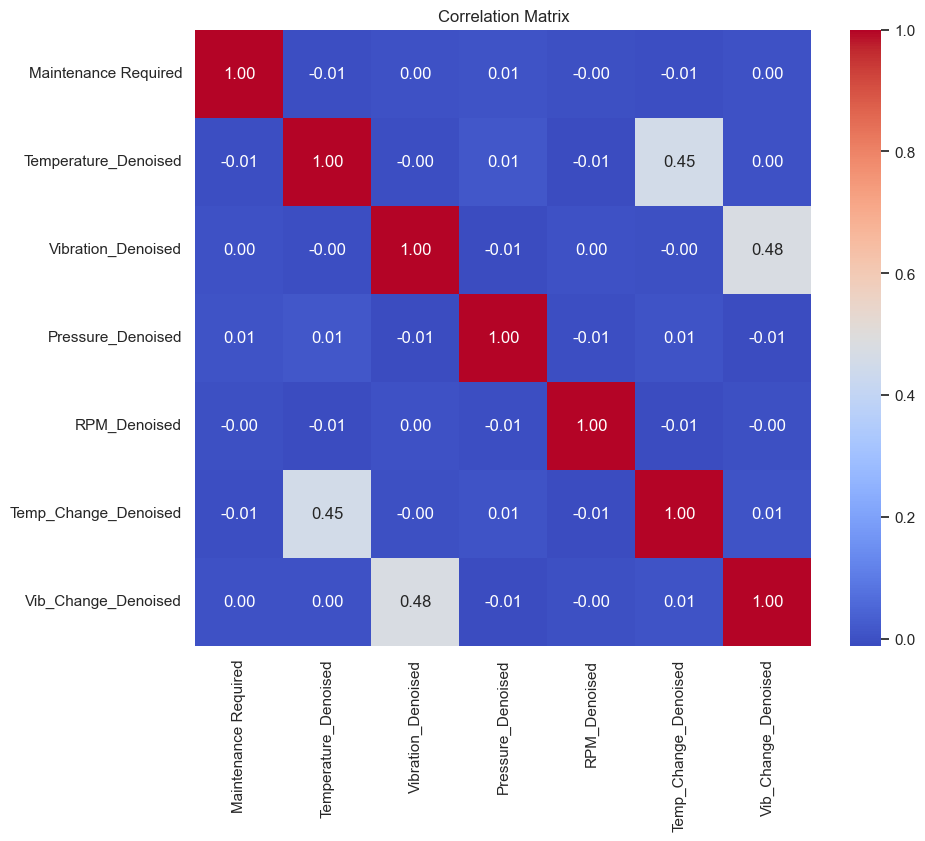

In [273]:
# remove Timestamp column for correlation
df_denoised = df[['Timestamp'] + ['Maintenance Required'] + [f"{col}_Denoised" for col in feature_cols]]
print(df_denoised.columns)
# correlation matrix
plt.figure(figsize=(10, 8))
corr = df_denoised.drop(columns=['Timestamp']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [275]:
df_denoised.columns

Index(['Timestamp', 'Maintenance Required', 'Temperature_Denoised',
       'Vibration_Denoised', 'Pressure_Denoised', 'RPM_Denoised',
       'Temp_Change_Denoised', 'Vib_Change_Denoised'],
      dtype='object')

# A Comprehensive Feature Engineering

In [281]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.fft import fft
from scipy.signal import welch
from scipy.spatial.distance import mahalanobis
import pywt
import logging
from uuid import uuid4

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Helper function to handle missing values
def fill_missing(df, cols, method='ffill'):
    """Fill missing values in specified columns."""
    for col in cols:
        if method == 'ffill':
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        elif method == 'mean':
            df[col] = df[col].fillna(df[col].mean())
    return df

# 1. Extended Time-Based Features
def extract_time_features(df, timestamp_col='Timestamp'):
    """Extract cyclic, event-based, and operational time features."""
    try:
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
        
        # Basic time components
        df['hour'] = df[timestamp_col].dt.hour
        df['day_of_week'] = df[timestamp_col].dt.dayofweek
        df['month'] = df[timestamp_col].dt.month
        df['quarter'] = df[timestamp_col].dt.quarter
        
        # Cyclic encodings
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        
        # Time since last maintenance
        df['time_since_last_maintenance'] = (
            df[timestamp_col] - df[timestamp_col].where(df['Maintenance Required'] == 1).ffill()
        ).dt.total_seconds() / 3600
        df['time_since_last_maintenance'] = df['time_since_last_maintenance'].fillna(0)
        
        # Time until next maintenance (for labeled data)
        df['time_until_next_maintenance'] = (
            df[timestamp_col].where(df['Maintenance Required'] == 1).bfill() - df[timestamp_col]
        ).dt.total_seconds() / 3600
        df['time_until_next_maintenance'] = df['time_until_next_maintenance'].clip(lower=0)
        
        # Operational period flags (e.g., shift-based)
        df['is_night_shift'] = df['hour'].between(22, 6).astype(int)
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        
        logging.info("Extracted time-based features")
        return df
    except Exception as e:
        logging.error(f"Error in extract_time_features: {e}")
        raise

# 2. Enhanced Lag and Rolling Window Features
def add_lag_features(df, cols, lags=[1, 3, 6, 12], group_col=None):
    """Add lagged features, optionally grouped by equipment."""
    try:
        df = df.copy()
        for col in cols:
            for lag in lags:
                if group_col:
                    df[f'{col}_lag{lag}'] = df.groupby(group_col)[col].shift(lag)
                else:
                    df[f'{col}_lag{lag}'] = df[col].shift(lag)
        logging.info("Added lag features")
        return df
    except Exception as e:
        logging.error(f"Error in add_lag_features: {e}")
        raise

def add_rolling_stats(df, cols, windows=[6, 12, 24, 48], group_col=None):
    """Add rolling statistics (mean, std, min, max, EMA)."""
    try:
        df = df.copy()
        for col in cols:
            for win in windows:
                if group_col:
                    rolling = df.groupby(group_col)[col].rolling(win, min_periods=1)
                else:
                    rolling = df[col].rolling(win, min_periods=1)
                
                df[f'{col}_roll_mean_{win}'] = rolling.mean().reset_index(level=0, drop=True)
                df[f'{col}_roll_std_{win}'] = rolling.std().reset_index(level=0, drop=True)
                df[f'{col}_roll_min_{win}'] = rolling.min().reset_index(level=0, drop=True)
                df[f'{col}_roll_max_{win}'] = rolling.max().reset_index(level=0, drop=True)
                
                # Exponential Moving Average
                if group_col:
                    df[f'{col}_ema_{win}'] = df.groupby(group_col)[col].ewm(span=win, adjust=False).mean().reset_index(level=0, drop=True)
                else:
                    df[f'{col}_ema_{win}'] = df[col].ewm(span=win, adjust=False).mean()
        logging.info("Added rolling statistics")
        return df
    except Exception as e:
        logging.error(f"Error in add_rolling_stats: {e}")
        raise

def add_rolling_trends(df, cols, windows=[12, 24], group_col=None):
    """Add rolling trend slopes."""
    try:
        df = df.copy()
        def slope(x):
            if len(x.dropna()) == len(x):
                X = np.arange(len(x)).reshape(-1, 1)
                return LinearRegression().fit(X, x).coef_[0]
            return np.nan
        
        for col in cols:
            for win in windows:
                if group_col:
                    df[f'{col}_trend_{win}'] = df.groupby(group_col)[col].rolling(win, min_periods=1).apply(slope).reset_index(level=0, drop=True)
                else:
                    df[f'{col}_trend_{win}'] = df[col].rolling(win, min_periods=1).apply(slope)
        logging.info("Added rolling trends")
        return df
    except Exception as e:
        logging.error(f"Error in add_rolling_trends: {e}")
        raise

def add_multi_step_diff(df, cols, steps=[1, 3, 6], group_col=None):
    """Add multi-step differences."""
    try:
        df = df.copy()
        for col in cols:
            for step in steps:
                if group_col:
                    df[f'{col}_diff_{step}'] = df.groupby(group_col)[col].diff(step)
                else:
                    df[f'{col}_diff_{step}'] = df[col].diff(step)
        logging.info("Added multi-step differences")
        return df
    except Exception as e:
        logging.error(f"Error in add_multi_step_diff: {e}")
        raise

# 3. Advanced Frequency Features
def fft_features(signal, n_top=5):
    """Compute top FFT amplitudes."""
    try:
        signal = signal.dropna()
        if len(signal) < 2:
            return np.zeros(n_top)
        fft_vals = np.abs(fft(signal))
        return fft_vals[:n_top]
    except Exception as e:
        logging.error(f"Error in fft_features: {e}")
        return np.zeros(n_top)

def psd_features(signal, fs=1.0, n_top=5):
    """Compute top PSD values."""
    try:
        signal = signal.dropna()
        if len(signal) < 2:
            return np.zeros(n_top)
        f, Pxx = welch(signal, fs)
        return Pxx[:n_top]
    except Exception as e:
        logging.error(f"Error in psd_features: {e}")
        return np.zeros(n_top)

def wavelet_features(signal, wavelet='db4', level=3):
    """Compute wavelet transform coefficients."""
    try:
        signal = signal.dropna()
        if len(signal) < 2:
            return np.zeros(level)
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        return np.concatenate([c[:1] for c in coeffs])[:level]
    except Exception as e:
        logging.error(f"Error in wavelet_features: {e}")
        return np.zeros(level)

def add_frequency_features(df, cols, group_col=None):
    """Add FFT, PSD, and wavelet features for specified columns."""
    try:
        df = df.copy()
        for col in cols:
            if group_col:
                for gid, group in df.groupby(group_col):
                    fft_vals = fft_features(group[col], n_top=5)
                    psd_vals = psd_features(group[col], n_top=5)
                    wavelet_vals = wavelet_features(group[col], level=3)
                    for i in range(5):
                        df.loc[group.index, f'{col}_fft_{i}'] = fft_vals[i]
                        df.loc[group.index, f'{col}_psd_{i}'] = psd_vals[i]
                    for i in range(3):
                        df.loc[group.index, f'{col}_wavelet_{i}'] = wavelet_vals[i]
            else:
                fft_vals = fft_features(df[col], n_top=5)
                psd_vals = psd_features(df[col], n_top=5)
                wavelet_vals = wavelet_features(df[col], level=3)
                for i in range(5):
                    df[f'{col}_fft_{i}'] = fft_vals[i]
                for i in range(5):
                    df[f'{col}_psd_{i}'] = psd_vals[i]
                for i in range(3):
                    df[f'{col}_wavelet_{i}'] = wavelet_vals[i]
        logging.info("Added frequency features")
        return df
    except Exception as e:
        logging.error(f"Error in add_frequency_features: {e}")
        raise

# 4. Robust Anomaly-Based Features
def add_zscore(df, cols, windows=[24, 48], group_col=None):
    """Add z-scores for specified columns."""
    try:
        df = df.copy()
        for col in cols:
            for win in windows:
                if group_col:
                    mean = df.groupby(group_col)[col].rolling(win, min_periods=1).mean().reset_index(level=0, drop=True)
                    std = df.groupby(group_col)[col].rolling(win, min_periods=1).std().reset_index(level=0, drop=True)
                else:
                    mean = df[col].rolling(win, min_periods=1).mean()
                    std = df[col].rolling(win, min_periods=1).std()
                df[f'{col}_zscore_{win}'] = (df[col] - mean) / (std + 1e-6)
        logging.info("Added z-score features")
        return df
    except Exception as e:
        logging.error(f"Error in add_zscore: {e}")
        raise

def add_threshold_flags(df, cols, percentiles=[95, 99], group_col=None):
    """Add dynamic threshold flags based on percentiles."""
    try:
        df = df.copy()
        for col in cols:
            if group_col:
                thresholds = df.groupby(group_col)[col].quantile([p/100 for p in percentiles])
                for p in percentiles:
                    for gid in df[group_col].unique():
                        thresh = thresholds.loc[gid, p/100]
                        df.loc[df[group_col] == gid, f'{col}_above_p{p}'] = (df[col] > thresh).astype(int)
            else:
                thresholds = df[col].quantile([p/100 for p in percentiles])
                for p in percentiles:
                    df[f'{col}_above_p{p}'] = (df[col] > thresholds[p/100]).astype(int)
        logging.info("Added threshold flags")
        return df
    except Exception as e:
        logging.error(f"Error in add_threshold_flags: {e}")
        raise

def add_mahalanobis_distance(df, cols, window=24, group_col=None):
    """Add Mahalanobis distance for multivariate anomaly detection."""
    try:
        df = df.copy()
        def calc_maha(group):
            # Ensure group has enough data and no missing values
            if len(group) < 2 or group.isna().any().any():
                return np.full(len(group), np.nan)
            # Check for sufficient variation (non-zero variance)
            if group.std().min() < 1e-6:
                return np.full(len(group), np.nan)
            try:
                cov = np.cov(group.T, bias=True)
                # Check if covariance matrix is singular
                if np.linalg.cond(cov) > 1e10:  # High condition number indicates near-singularity
                    return np.full(len(group), np.nan)
                cov_inv = np.linalg.pinv(cov)
                mean = group.mean()
                return [mahalanobis(row, mean, cov_inv) for row in group.values]
            except np.linalg.LinAlgError:
                return np.full(len(group), np.nan)
        
        if group_col:
            for gid, group in df.groupby(group_col):
                rolling_data = group[cols].rolling(window, min_periods=2)  # Require at least 2 points
                maha_values = []
                for window_data in rolling_data:
                    if len(window_data.dropna()) >= 2:
                        maha = calc_maha(window_data)
                        maha_values.append(maha[-1] if maha is not None and not np.all(np.isnan(maha)) else np.nan)
                    else:
                        maha_values.append(np.nan)
                df.loc[group.index, 'mahalanobis_dist'] = maha_values
        else:
            rolling_data = df[cols].rolling(window, min_periods=2)  # Require at least 2 points
            maha_values = []
            for window_data in rolling_data:
                if len(window_data.dropna()) >= 2:
                    maha = calc_maha(window_data)
                    maha_values.append(maha[-1] if maha is not None and not np.all(np.isnan(maha)) else np.nan)
                else:
                    maha_values.append(np.nan)
            df['mahalanobis_dist'] = maha_values
        
        logging.info("Added Mahalanobis distance")
        return df
    except Exception as e:
        logging.error(f"Error in add_mahalanobis_distance: {e}")
        raise

# 5. Expanded Interaction Features
def add_interactions(df, sensor_cols):
    """Add sensor ratios, polynomial interactions, and time-weighted features."""
    try:
        df = df.copy()
        # Ratios
        df['temp_by_pressure'] = df['Temperature_Denoised'] / (df['Pressure_Denoised'] + 1e-6)
        df['vib_by_rpm'] = df['Vibration_Denoised'] / (df['RPM_Denoised'] + 1e-6)
        
        # Polynomial interactions
        for col1 in sensor_cols:
            for col2 in sensor_cols:
                if col1 < col2:
                    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
        
        # Time-weighted features
        df['temp_time_weighted'] = df['Temperature_Denoised'] * df['hour_sin']
        df['vib_time_weighted'] = df['Vibration_Denoised'] * df['time_since_last_maintenance']
        df['temp_change_interaction'] = df['Temp_Change_Denoised'] * df['time_since_last_maintenance']
        
        logging.info("Added interaction features")
        return df
    except Exception as e:
        logging.error(f"Error in add_interactions: {e}")
        raise

# 6. Comprehensive Event-Based Features
def add_maintenance_history(df, timestamp_col='Timestamp', sensor_cols=None, group_col=None):
    """Add cumulative counts, average time between maintenance, and post-maintenance deltas."""
    try:
        df = df.copy()
        if sensor_cols is None:
            sensor_cols = []
        if group_col:
            df['cum_maintenance_count'] = df.groupby(group_col)['Maintenance Required'].cumsum()
            maintenance_times = df[df['Maintenance Required'] == 1].groupby(group_col)[timestamp_col].diff().dt.total_seconds() / 3600
            df['avg_time_between_maintenance'] = df[group_col].map(maintenance_times.mean())
            for col in sensor_cols:
                df[f'{col}_post_maintenance'] = df.groupby(group_col)[col].shift(-1).where(df['Maintenance Required'] == 1).ffill()
        else:
            df['cum_maintenance_count'] = df['Maintenance Required'].cumsum()
            maintenance_times = df[df['Maintenance Required'] == 1][timestamp_col].diff().dt.total_seconds() / 3600
            df['avg_time_between_maintenance'] = maintenance_times.mean()
            for col in sensor_cols:
                df[f'{col}_post_maintenance'] = df[col].shift(-1).where(df['Maintenance Required'] == 1).ffill()
        logging.info("Added maintenance history features")
        return df
    except Exception as e:
        logging.error(f"Error in add_maintenance_history: {e}")
        raise

# 7. Domain-Specific Features
def add_usage_proxies(df, sensor_cols):
    """Add cumulative usage and operating condition flags."""
    try:
        df = df.copy()
        df['cumulative_vibration'] = df['Vibration_Denoised'].cumsum()
        df['rpm_integral'] = df['RPM_Denoised'].cumsum()
        
        # Operating condition flags
        df['high_load'] = (df['RPM_Denoised'] > df['RPM_Denoised'].quantile(0.8)).astype(int)
        df['high_temp'] = (df['Temperature_Denoised'] > df['Temperature_Denoised'].quantile(0.80)).astype(int)
        df['high_vibration'] = (df['Vibration_Denoised'] > df['Vibration_Denoised'].quantile(0.8)).astype(int)
        df['high_pressure'] = (df['Pressure_Denoised'] > df['Pressure_Denoised'].quantile(0.8)).astype(int)
        df['high_temp_change'] = (df['Temp_Change_Denoised'] > df['Temp_Change_Denoised'].quantile(0.8)).astype(int)
        df['high_vib_change'] = (df['Vib_Change_Denoised'] > df['Vib_Change_Denoised'].quantile(0.8)).astype(int)
        
        # Environmental interaction proxy (if external data unavailable)
        df['temp_anomaly'] = df['Temperature_Denoised'] - df['Temperature_Denoised'].rolling(168, min_periods=1).mean()
        
        logging.info("Added usage and condition features")
        return df
    except Exception as e:
        logging.error(f"Error in add_usage_proxies: {e}")
        raise

# 8. Feature Grouping for Multi-Equipment
def add_fleet_features(df, sensor_cols, group_col):
    """Add fleet-level statistics."""
    try:
        df = df.copy()
        for col in sensor_cols:
            df[f'{col}_fleet_mean'] = df.groupby(group_col)[col].transform('mean')
            df[f'{col}_fleet_std'] = df.groupby(group_col)[col].transform('std')
            df[f'{col}_fleet_anomaly'] = (df[col] - df[f'{col}_fleet_mean']) / (df[f'{col}_fleet_std'] + 1e-6)
        logging.info("Added fleet-level features")
        return df
    except Exception as e:
        logging.error(f"Error in add_fleet_features: {e}")
        raise

# Main Feature Engineering Pipeline
def engineer_features(
    df,
    sensor_cols=['Temperature_Denoised', 'Vibration_Denoised', 'Pressure_Denoised', 'RPM_Denoised'],
    timestamp_col='Timestamp',
    group_col=None,
    lags=[1, 3, 6, 12],
    windows=[6, 12, 24, 48],
    freq_window=128
):
    """Comprehensive feature engineering pipeline."""
    try:
        df = df.copy()
        
        # Handle missing values
        df = fill_missing(df, sensor_cols + [timestamp_col], method='ffill')
        df = fill_missing(df, ['Maintenance Required'], method='mean')
        
        # Apply transformations
        df = extract_time_features(df, timestamp_col=timestamp_col)
        df = add_lag_features(df, sensor_cols, lags=lags, group_col=group_col)
        df = add_rolling_stats(df, sensor_cols, windows=windows, group_col=group_col)
        df = add_rolling_trends(df, sensor_cols, windows=windows[:2], group_col=group_col)
        df = add_multi_step_diff(df, sensor_cols, steps=[1, 3, 6], group_col=group_col)
        df = add_frequency_features(df, ['Vibration_Denoised', 'RPM_Denoised'], group_col=group_col)
        df = add_zscore(df, sensor_cols, windows=windows, group_col=group_col)
        df = add_threshold_flags(df, sensor_cols, percentiles=[95, 99], group_col=group_col)
        df = add_mahalanobis_distance(df, sensor_cols, window=windows[1], group_col=group_col)
        df = add_interactions(df, sensor_cols)
        df = add_maintenance_history(df, timestamp_col=timestamp_col, sensor_cols=sensor_cols, group_col=group_col)
        df = add_usage_proxies(df, sensor_cols)
        
        if group_col:
            df = add_fleet_features(df, sensor_cols, group_col)
        
        # Drop rows with excessive missing values
        df = df.dropna(thresh=len(df.columns) * 0.8)
        
        logging.info("Feature engineering completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error in engineer_features: {e}")
        raise

# Example usage
if __name__ == "__main__":
    # Sample data
    dates = pd.date_range('2023-01-01', '2023-01-10', freq='H')
    data = {
        'Timestamp': dates,
        'Maintenance Required': np.random.randint(0, 2, len(dates)),
        'Temperature_Denoised': np.random.normal(70, 5, len(dates)),
        'Vibration_Denoised': np.random.normal(0.1, 0.02, len(dates)),
        'Pressure_Denoised': np.random.normal(100, 10, len(dates)),
        'RPM_Denoised': np.random.normal(1500, 100, len(dates)),
        'Temp_Change_Denoised': np.random.normal(0, 1, len(dates)),
        'Vib_Change_Denoised': np.random.normal(0, 0.01, len(dates))
    }
    df = pd.DataFrame(data)
    
    # Engineer features
    df = engineer_features(df)
    print(df.head())

/var/folders/hv/j5l48m8d23vblzg5fd3twbcw0000gn/T/ipykernel_37094/2921722766.py:442: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2023-01-01', '2023-01-10', freq='H')
/var/folders/hv/j5l48m8d23vblzg5fd3twbcw0000gn/T/ipykernel_37094/2921722766.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
2025-04-14 13:22:07,045 - INFO - Extracted time-based features
2025-04-14 13:22:07,048 - INFO - Added lag features
2025-04-14 13:22:07,066 - INFO - Added rolling statistics
2025-04-14 13:22:07,741 - INFO - Added rolling trends
2025-04-14 13:22:07,751 - INFO - Added multi-step differences
/Users/pouyaabbasi/Documents/Projects/sequential_anomaly_detection/venv/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input l

            Timestamp  Maintenance Required  Temperature_Denoised  \
1 2023-01-01 01:00:00                     0             67.429237   
2 2023-01-01 02:00:00                     0             71.362579   
3 2023-01-01 03:00:00                     1             60.701102   
4 2023-01-01 04:00:00                     0             74.403572   
5 2023-01-01 05:00:00                     1             78.467754   

   Vibration_Denoised  Pressure_Denoised  RPM_Denoised  Temp_Change_Denoised  \
1            0.083327         104.507388   1458.344237              0.386155   
2            0.113489         103.500112   1611.979035              0.311201   
3            0.106953          93.471126   1497.348475              0.345202   
4            0.081570         112.930233   1537.807080             -0.062369   
5            0.092170         100.144902   1455.799317             -0.177663   

   Vib_Change_Denoised  hour  day_of_week  ...  avg_time_between_maintenance  \
1            -0.001659  

# TO DO


- change the FFT
- add_interactions should be kernel based
- PCA
- Apply visualisation for after each step of pipeline

# Modified the engineer_features
the n_top in "# 3. Advanced Frequency Features" was replaced with percentile.


In [ ]:

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Helper function to handle missing values
def fill_missing(df, cols, method='ffill'):
    """Fill missing values in specified columns."""
    for col in cols:
        if method == 'ffill':
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        elif method == 'mean':
            df[col] = df[col].fillna(df[col].mean())
    return df

# 1. Extended Time-Based Features
def extract_time_features(df, timestamp_col='Timestamp'):
    """Extract cyclic, event-based, and operational time features."""
    try:
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
        
        # Basic time components
        df['hour'] = df[timestamp_col].dt.hour
        df['day_of_week'] = df[timestamp_col].dt.dayofweek
        df['month'] = df[timestamp_col].dt.month
        df['quarter'] = df[timestamp_col].dt.quarter
        
        # Cyclic encodings
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        
        # Time since last maintenance
        df['time_since_last_maintenance'] = (
            df[timestamp_col] - df[timestamp_col].where(df['Maintenance Required'] == 1).ffill()
        ).dt.total_seconds() / 3600
        df['time_since_last_maintenance'] = df['time_since_last_maintenance'].fillna(0)
        
        # Time until next maintenance (for labeled data)
        df['time_until_next_maintenance'] = (
            df[timestamp_col].where(df['Maintenance Required'] == 1).bfill() - df[timestamp_col]
        ).dt.total_seconds() / 3600
        df['time_until_next_maintenance'] = df['time_until_next_maintenance'].clip(lower=0)
        
        # Operational period flags (e.g., shift-based)
        df['is_night_shift'] = df['hour'].between(22, 6).astype(int)
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        
        logging.info("Extracted time-based features")
        return df
    except Exception as e:
        logging.error(f"Error in extract_time_features: {e}")
        raise

# 2. Enhanced Lag and Rolling Window Features
def add_lag_features(df, cols, lags=[1, 3, 6, 12], group_col=None):
    """Add lagged features, optionally grouped by equipment."""
    try:
        df = df.copy()
        for col in cols:
            for lag in lags:
                if group_col:
                    df[f'{col}_lag{lag}'] = df.groupby(group_col)[col].shift(lag)
                else:
                    df[f'{col}_lag{lag}'] = df[col].shift(lag)
        logging.info("Added lag features")
        return df
    except Exception as e:
        logging.error(f"Error in add_lag_features: {e}")
        raise

def add_rolling_stats(df, cols, windows=[6, 12, 24, 48], group_col=None):
    """Add rolling statistics (mean, std, min, max, EMA)."""
    try:
        df = df.copy()
        for col in cols:
            for win in windows:
                if group_col:
                    rolling = df.groupby(group_col)[col].rolling(win, min_periods=1)
                else:
                    rolling = df[col].rolling(win, min_periods=1)
                
                df[f'{col}_roll_mean_{win}'] = rolling.mean().reset_index(level=0, drop=True)
                df[f'{col}_roll_std_{win}'] = rolling.std().reset_index(level=0, drop=True)
                df[f'{col}_roll_min_{win}'] = rolling.min().reset_index(level=0, drop=True)
                df[f'{col}_roll_max_{win}'] = rolling.max().reset_index(level=0, drop=True)
                
                # Exponential Moving Average
                if group_col:
                    df[f'{col}_ema_{win}'] = df.groupby(group_col)[col].ewm(span=win, adjust=False).mean().reset_index(level=0, drop=True)
                else:
                    df[f'{col}_ema_{win}'] = df[col].ewm(span=win, adjust=False).mean()
        logging.info("Added rolling statistics")
        return df
    except Exception as e:
        logging.error(f"Error in add_rolling_stats: {e}")
        raise

def add_rolling_trends(df, cols, windows=[12, 24], group_col=None):
    """Add rolling trend slopes."""
    try:
        df = df.copy()
        def slope(x):
            if len(x.dropna()) == len(x):
                X = np.arange(len(x)).reshape(-1, 1)
                return LinearRegression().fit(X, x).coef_[0]
            return np.nan
        
        for col in cols:
            for win in windows:
                if group_col:
                    df[f'{col}_trend_{win}'] = df.groupby(group_col)[col].rolling(win, min_periods=1).apply(slope).reset_index(level=0, drop=True)
                else:
                    df[f'{col}_trend_{win}'] = df[col].rolling(win, min_periods=1).apply(slope)
        logging.info("Added rolling trends")
        return df
    except Exception as e:
        logging.error(f"Error in add_rolling_trends: {e}")
        raise

def add_multi_step_diff(df, cols, steps=[1, 3, 6], group_col=None):
    """Add multi-step differences."""
    try:
        df = df.copy()
        for col in cols:
            for step in steps:
                if group_col:
                    df[f'{col}_diff_{step}'] = df.groupby(group_col)[col].diff(step)
                else:
                    df[f'{col}_diff_{step}'] = df[col].diff(step)
        logging.info("Added multi-step differences")
        return df
    except Exception as e:
        logging.error(f"Error in add_multi_step_diff: {e}")
        raise

# 3. Advanced Frequency Features
def fft_features(signal, percentile=95, max_components=10):
    """Compute FFT amplitudes above the specified percentile."""
    try:
        signal = signal.dropna()
        if len(signal) < 2:
            return np.zeros(max_components)
        fft_vals = np.abs(fft(signal))
        if len(fft_vals) == 0:
            return np.zeros(max_components)
        threshold = np.percentile(fft_vals, percentile)
        significant_vals = fft_vals[fft_vals > threshold]
        # Sort by magnitude (descending) and cap at max_components
        significant_vals = np.sort(significant_vals)[::-1][:max_components]
        # Pad with zeros if fewer than max_components
        result = np.zeros(max_components)
        result[:len(significant_vals)] = significant_vals
        return result
    except Exception as e:
        logging.error(f"Error in fft_features: {e}")
        return np.zeros(max_components)

def psd_features(signal, fs=1.0, percentile=95, max_components=10):
    """Compute PSD values above the specified percentile."""
    try:
        signal = signal.dropna()
        if len(signal) < 2:
            return np.zeros(max_components)
        f, Pxx = welch(signal, fs)
        if len(Pxx) == 0:
            return np.zeros(max_components)
        threshold = np.percentile(Pxx, percentile)
        significant_vals = Pxx[Pxx > threshold]
        # Sort by power (descending) and cap at max_components
        significant_vals = np.sort(significant_vals)[::-1][:max_components]
        # Pad with zeros if fewer than max_components
        result = np.zeros(max_components)
        result[:len(significant_vals)] = significant_vals
        return result
    except Exception as e:
        logging.error(f"Error in psd_features: {e}")
        return np.zeros(max_components)

def wavelet_features(signal, wavelet='db4', percentile=95, max_components=10):
    """Compute wavelet coefficients above the specified percentile."""
    try:
        signal = signal.dropna()
        if len(signal) < 2:
            return np.zeros(max_components)
        # Use a reasonable max level based on signal length
        max_level = min(pywt.dwt_max_level(len(signal), wavelet), 5)
        coeffs = pywt.wavedec(signal, wavelet, level=max_level)
        # Flatten coefficients and take absolute values
        all_coeffs = np.concatenate([np.abs(c) for c in coeffs])
        if len(all_coeffs) == 0:
            return np.zeros(max_components)
        threshold = np.percentile(all_coeffs, percentile)
        significant_coeffs = all_coeffs[all_coeffs > threshold]
        # Sort by magnitude (descending) and cap at max_components
        significant_coeffs = np.sort(significant_coeffs)[::-1][:max_components]
        # Pad with zeros if fewer than max_components
        result = np.zeros(max_components)
        result[:len(significant_coeffs)] = significant_coeffs
        return result
    except Exception as e:
        logging.error(f"Error in wavelet_features: {e}")
        return np.zeros(max_components)

def add_frequency_features(df, cols, window=128, percentile=95, max_components=10, group_col=None):
    """Add FFT, PSD, and wavelet features based on percentile thresholds."""
    try:
        df = df.copy()
        for col in cols:
            if group_col:
                for gid, group in df.groupby(group_col):
                    fft_vals = fft_features(group[col], percentile=percentile, max_components=max_components)
                    psd_vals = psd_features(group[col], percentile=percentile, max_components=max_components)
                    wavelet_vals = wavelet_features(group[col], percentile=percentile, max_components=max_components)
                    for i in range(max_components):
                        df.loc[group.index, f'{col}_fft_p{percentile}_{i}'] = fft_vals[i]
                        df.loc[group.index, f'{col}_psd_p{percentile}_{i}'] = psd_vals[i]
                        df.loc[group.index, f'{col}_wavelet_p{percentile}_{i}'] = wavelet_vals[i]
            else:
                fft_vals = fft_features(df[col], percentile=percentile, max_components=max_components)
                psd_vals = psd_features(df[col], percentile=percentile, max_components=max_components)
                wavelet_vals = wavelet_features(df[col], percentile=percentile, max_components=max_components)
                for i in range(max_components):
                    df[f'{col}_fft_p{percentile}_{i}'] = fft_vals[i]
                    df[f'{col}_psd_p{percentile}_{i}'] = psd_vals[i]
                    df[f'{col}_wavelet_p{percentile}_{i}'] = wavelet_vals[i]
        logging.info("Added frequency features")
        return df
    except Exception as e:
        logging.error(f"Error in add_frequency_features: {e}")
        raise

# 4. Robust Anomaly-Based Features
def add_zscore(df, cols, windows=[24, 48], group_col=None):
    """Add z-scores for specified columns."""
    try:
        df = df.copy()
        for col in cols:
            for win in windows:
                if group_col:
                    mean = df.groupby(group_col)[col].rolling(win, min_periods=1).mean().reset_index(level=0, drop=True)
                    std = df.groupby(group_col)[col].rolling(win, min_periods=1).std().reset_index(level=0, drop=True)
                else:
                    mean = df[col].rolling(win, min_periods=1).mean()
                    std = df[col].rolling(win, min_periods=1).std()
                df[f'{col}_zscore_{win}'] = (df[col] - mean) / (std + 1e-6)
        logging.info("Added z-score features")
        return df
    except Exception as e:
        logging.error(f"Error in add_zscore: {e}")
        raise

def add_threshold_flags(df, cols, percentiles=[95, 99], group_col=None):
    """Add dynamic threshold flags based on percentiles."""
    try:
        df = df.copy()
        for col in cols:
            if group_col:
                thresholds = df.groupby(group_col)[col].quantile([p/100 for p in percentiles])
                for p in percentiles:
                    for gid in df[group_col].unique():
                        thresh = thresholds.loc[gid, p/100]
                        df.loc[df[group_col] == gid, f'{col}_above_p{p}'] = (df[col] > thresh).astype(int)
            else:
                thresholds = df[col].quantile([p/100 for p in percentiles])
                for p in percentiles:
                    df[f'{col}_above_p{p}'] = (df[col] > thresholds[p/100]).astype(int)
        logging.info("Added threshold flags")
        return df
    except Exception as e:
        logging.error(f"Error in add_threshold_flags: {e}")
        raise

def add_mahalanobis_distance(df, cols, window=24, group_col=None):
    """Add Mahalanobis distance for multivariate anomaly detection."""
    try:
        df = df.copy()
        def calc_maha(group):
            if len(group) < 2 or group.isna().any().any():
                return np.full(len(group), np.nan)
            if group.std().min() < 1e-6:
                return np.full(len(group), np.nan)
            try:
                cov = np.cov(group.T, bias=True)
                if np.linalg.cond(cov) > 1e10:
                    return np.full(len(group), np.nan)
                cov_inv = np.linalg.pinv(cov)
                mean = group.mean()
                return [mahalanobis(row, mean, cov_inv) for row in group.values]
            except np.linalg.LinAlgError:
                return np.full(len(group), np.nan)
        
        if group_col:
            for gid, group in df.groupby(group_col):
                rolling_data = group[cols].rolling(window, min_periods=2)
                maha_values = []
                for window_data in rolling_data:
                    if len(window_data.dropna()) >= 2:
                        maha = calc_maha(window_data)
                        maha_values.append(maha[-1] if maha is not None and not np.all(np.isnan(maha)) else np.nan)
                    else:
                        maha_values.append(np.nan)
                df.loc[group.index, 'mahalanobis_dist'] = maha_values
        else:
            rolling_data = df[cols].rolling(window, min_periods=2)
            maha_values = []
            for window_data in rolling_data:
                if len(window_data.dropna()) >= 2:
                    maha = calc_maha(window_data)
                    maha_values.append(maha[-1] if maha is not None and not np.all(np.isnan(maha)) else np.nan)
                else:
                    maha_values.append(np.nan)
            df['mahalanobis_dist'] = maha_values
        
        logging.info("Added Mahalanobis distance")
        return df
    except Exception as e:
        logging.error(f"Error in add_mahalanobis_distance: {e}")
        raise

# 5. Expanded Interaction Features
def add_interactions(df, sensor_cols):
    """Add sensor ratios, polynomial interactions, and time-weighted features."""
    try:
        df = df.copy()
        df['temp_by_pressure'] = df['Temperature_Denoised'] / (df['Pressure_Denoised'] + 1e-6)
        df['vib_by_rpm'] = df['Vibration_Denoised'] / (df['RPM_Denoised'] + 1e-6)
        
        for col1 in sensor_cols:
            for col2 in sensor_cols:
                if col1 < col2:
                    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
        
        df['temp_time_weighted'] = df['Temperature_Denoised'] * df['hour_sin']
        df['vib_time_weighted'] = df['Vibration_Denoised'] * df['time_since_last_maintenance']
        df['temp_change_interaction'] = df['Temp_Change_Denoised'] * df['time_since_last_maintenance']
        df['vib_change_interaction'] = df['Vib_Change_Denoised'] * df['time_since_last_maintenance']
        df['pressure_change_interaction'] = df['Pressure_Denoised'] * df['time_since_last_maintenance']
        df['rpm_change_interaction'] = df['RPM_Denoised'] * df['time_since_last_maintenance']
        df['temp_by_vib'] = df['Temperature_Denoised'] / (df['Vibration_Denoised'] + 1e-6)
        df['vib_by_temp'] = df['Vibration_Denoised'] / (df['Temperature_Denoised'] + 1e-6)
        df['pressure_by_temp'] = df['Pressure_Denoised'] / (df['Temperature_Denoised'] + 1e-6)
        df['pressure_by_vib'] = df['Pressure_Denoised'] / (df['Vibration_Denoised'] + 1e-6)
        df['pressure_by_rpm'] = df['Pressure_Denoised'] / (df['RPM_Denoised'] + 1e-6)
        df['rpm_by_temp'] = df['RPM_Denoised'] / (df['Temperature_Denoised'] + 1e-6)
        df['rpm_by_vib'] = df['RPM_Denoised'] / (df['Vibration_Denoised'] + 1e-6)
        df['rpm_by_pressure'] = df['RPM_Denoised'] / (df['Pressure_Denoised'] + 1e-6)
        
        logging.info("Added interaction features")
        return df
    except Exception as e:
        logging.error(f"Error in add_interactions: {e}")
        raise

# 6. Comprehensive Event-Based Features
def add_maintenance_history(df, timestamp_col='Timestamp', sensor_cols=None, group_col=None):
    """Add cumulative counts, average time between maintenance, and post-maintenance deltas."""
    try:
        df = df.copy()
        if sensor_cols is None:
            sensor_cols = []
        if group_col:
            df['cum_maintenance_count'] = df.groupby(group_col)['Maintenance Required'].cumsum()
            maintenance_times = df[df['Maintenance Required'] == 1].groupby(group_col)[timestamp_col].diff().dt.total_seconds() / 3600
            df['avg_time_between_maintenance'] = df[group_col].map(maintenance_times.mean())
            for col in sensor_cols:
                df[f'{col}_post_maintenance'] = df.groupby(group_col)[col].shift(-1).where(df['Maintenance Required'] == 1).ffill()
        else:
            df['cum_maintenance_count'] = df['Maintenance Required'].cumsum()
            maintenance_times = df[df['Maintenance Required'] == 1][timestamp_col].diff().dt.total_seconds() / 3600
            df['avg_time_between_maintenance'] = maintenance_times.mean()
            for col in sensor_cols:
                df[f'{col}_post_maintenance'] = df[col].shift(-1).where(df['Maintenance Required'] == 1).ffill()
        logging.info("Added maintenance history features")
        return df
    except Exception as e:
        logging.error(f"Error in add_maintenance_history: {e}")
        raise

# 7. Domain-Specific Features
def add_usage_proxies(df, sensor_cols):
    """Add cumulative usage and operating condition flags."""
    try:
        df = df.copy()
        df['cumulative_vibration'] = df['Vibration_Denoised'].cumsum()
        df['rpm_integral'] = df['RPM_Denoised'].cumsum()
        df['temp_integral'] = df['Temperature_Denoised'].cumsum()
        df['pressure_integral'] = df['Pressure_Denoised'].cumsum()
        df['vib_integral'] = df['Vibration_Denoised'].cumsum()
        df['temp_change_integral'] = df['Temp_Change_Denoised'].cumsum()
        df['vib_change_integral'] = df['Vib_Change_Denoised'].cumsum()
        df['pressure_change_integral'] = df['Pressure_Denoised'].cumsum()
        df['rpm_change_integral'] = df['RPM_Denoised'].cumsum()
        
        df['high_load'] = (df['RPM_Denoised'] > df['RPM_Denoised'].quantile(0.75)).astype(int)
        df['high_temp'] = (df['Temperature_Denoised'] > df['Temperature_Denoised'].quantile(0.90)).astype(int)
        df['high_vibration'] = (df['Vibration_Denoised'] > df['Vibration_Denoised'].quantile(0.90)).astype(int)
        df['high_pressure'] = (df['Pressure_Denoised'] > df['Pressure_Denoised'].quantile(0.90)).astype(int)
        
        df['temp_anomaly'] = df['Temperature_Denoised'] - df['Temperature_Denoised'].rolling(168, min_periods=1).mean()
        df['vib_anomaly'] = df['Vibration_Denoised'] - df['Vibration_Denoised'].rolling(168, min_periods=1).mean()
        df['pressure_anomaly'] = df['Pressure_Denoised'] - df['Pressure_Denoised'].rolling(168, min_periods=1).mean()
        df['rpm_anomaly'] = df['RPM_Denoised'] - df['RPM_Denoised'].rolling(168, min_periods=1).mean()
        
        logging.info("Added usage and condition features")
        return df
    except Exception as e:
        logging.error(f"Error in add_usage_proxies: {e}")
        raise

# 8. Feature Grouping for Multi-Equipment
def add_fleet_features(df, sensor_cols, group_col):
    """Add fleet-level statistics."""
    try:
        df = df.copy()
        for col in sensor_cols:
            df[f'{col}_fleet_mean'] = df.groupby(group_col)[col].transform('mean')
            df[f'{col}_fleet_std'] = df.groupby(group_col)[col].transform('std')
            df[f'{col}_fleet_anomaly'] = (df[col] - df[f'{col}_fleet_mean']) / (df[f'{col}_fleet_std'] + 1e-6)
        logging.info("Added fleet-level features")
        return df
    except Exception as e:
        logging.error(f"Error in add_fleet_features: {e}")
        raise

# Main Feature Engineering Pipeline
def engineer_features(
    df,
    sensor_cols=['Temperature_Denoised', 'Vibration_Denoised', 'Pressure_Denoised', 'RPM_Denoised'],
    timestamp_col='Timestamp',
    group_col=None,
    lags=[1, 3, 6, 12],
    windows=[6, 12, 24, 48],
    freq_window=128,
    freq_percentile=95,
    freq_max_components=10
):
    """Comprehensive feature engineering pipeline."""
    try:
        df = df.copy()
        
        df = fill_missing(df, sensor_cols + [timestamp_col], method='ffill')
        df = fill_missing(df, ['Maintenance Required'], method='mean')
        
        df = extract_time_features(df, timestamp_col=timestamp_col)
        df = add_lag_features(df, sensor_cols, lags=lags, group_col=group_col)
        df = add_rolling_stats(df, sensor_cols, windows=windows, group_col=group_col)
        df = add_rolling_trends(df, sensor_cols, windows=windows[:2], group_col=group_col)
        df = add_multi_step_diff(df, sensor_cols, steps=[1, 3, 6], group_col=group_col)
        df = add_frequency_features(df, ['Vibration_Denoised', 'RPM_Denoised'], 
                                 window=freq_window, percentile=freq_percentile, 
                                 max_components=freq_max_components, group_col=group_col)
        df = add_zscore(df, sensor_cols, windows=windows, group_col=group_col)
        df = add_threshold_flags(df, sensor_cols, percentiles=[95, 99], group_col=group_col)
        df = add_mahalanobis_distance(df, sensor_cols, window=windows[1], group_col=group_col)
        df = add_interactions(df, sensor_cols)
        df = add_maintenance_history(df, timestamp_col=timestamp_col, sensor_cols=sensor_cols, group_col=group_col)
        df = add_usage_proxies(df, sensor_cols)
        
        if group_col:
            df = add_fleet_features(df, sensor_cols, group_col)
        
        df = df.dropna(thresh=len(df.columns) * 0.8)
        
        logging.info("Feature engineering completed successfully")
        return df
    except Exception as e:
        logging.error(f"Error in engineer_features: {e}")
        raise

# Example usage
if __name__ == "__main__":
    dates = pd.date_range('2023-01-01', '2023-01-10', freq='H')
    data = {
        'Timestamp': dates,
        'Maintenance Required': np.random.randint(0, 2, len(dates)),
        'Temperature_Denoised': np.random.normal(70, 5, len(dates)),
        'Vibration_Denoised': np.random.normal(0.1, 0.02, len(dates)),
        'Pressure_Denoised': np.random.normal(100, 10, len(dates)),
        'RPM_Denoised': np.random.normal(1500, 100, len(dates)),
        'Temp_Change_Denoised': np.random.normal(0, 1, len(dates)),
        'Vib_Change_Denoised': np.random.normal(0, 0.01, len(dates))
    }
    df = pd.DataFrame(data)
    
    df = engineer_features(df)
    print(df.head())

/var/folders/hv/j5l48m8d23vblzg5fd3twbcw0000gn/T/ipykernel_37094/1604299736.py:452: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2023-01-01', '2023-01-10', freq='H')
/var/folders/hv/j5l48m8d23vblzg5fd3twbcw0000gn/T/ipykernel_37094/1604299736.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
2025-04-15 12:05:00,667 - INFO - Extracted time-based features
2025-04-15 12:05:00,675 - INFO - Added lag features
2025-04-15 12:05:00,697 - INFO - Added rolling statistics
2025-04-15 12:05:01,369 - INFO - Added rolling trends
2025-04-15 12:05:01,374 - INFO - Added multi-step differences
/Users/pouyaabbasi/Documents/Projects/sequential_anomaly_detection/venv/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input le

            Timestamp  Maintenance Required  Temperature_Denoised  \
1 2023-01-01 01:00:00                     0             73.983510   
2 2023-01-01 02:00:00                     1             70.075915   
3 2023-01-01 03:00:00                     1             65.125967   
4 2023-01-01 04:00:00                     0             73.227939   
5 2023-01-01 05:00:00                     0             70.096906   

   Vibration_Denoised  Pressure_Denoised  RPM_Denoised  Temp_Change_Denoised  \
1            0.095579         107.707502   1503.390272             -1.007912   
2            0.101387         123.817135   1380.959226             -0.339759   
3            0.103852         108.272361   1592.597510              0.231607   
4            0.147842         111.598400   1490.892414              0.786406   
5            0.058013          94.940338   1482.240401             -0.559546   

   Vib_Change_Denoised  hour  day_of_week  ...  avg_time_between_maintenance  \
1            -0.013816  